In [7]:
project_root = None

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

if project_root is None:
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path(project_root)
    
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.cleaner import DataCleaner
from src.data.loader import DataLoader
from src.models.semi_supervised import (
    mask_labels,
    SemiSupervisedAttrition
)
from src.evaluation.metrics import classification_metrics
from src.models.supervised import LogisticModel

with open(PROJECT_ROOT / "configs" / "params.yaml") as f:
    cfg = yaml.safe_load(f)

DATA_PATH = PROJECT_ROOT / cfg["paths"]["raw_data"]
TARGET = cfg["target"]


In [9]:
df = DataLoader(DATA_PATH).load()
X, y, _ = DataCleaner().clean(df, target=TARGET)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=cfg["seed"],
    stratify=y
)

print("Train size:", len(y_train_full))
print("Test size:", len(y_test))

Train size: 1031
Test size: 442


In [10]:
label_ratios = [0.1, 0.2, 0.3]

results = []

for ratio in label_ratios:
    print(f"\n=== Labeled ratio: {int(ratio*100)}% ===")
    
    y_semi, mask = mask_labels(
        y_train_full,
        labeled_ratio=ratio,
        seed=cfg['seed']
    )
    
    X_labeled = X_train_full[mask]
    y_labeled = y_train_full[mask]
    
    print("Labeled samples:", len(y_labeled))
    
    sup_model = LogisticModel(
        cfg['seed']
    )
    
    sup_model.model.fit(X_labeled, y_labeled)
    
    y_sup_pred = sup_model.predict(X_test)
    y_sup_prob = sup_model.predict_proba(X_test)
    
    sup_metrics = classification_metrics(
        y_test,
        y_sup_pred,
        y_sup_prob
    )
    
    print("Supervised:", sup_metrics)
    
    semi_model = SemiSupervisedAttrition(seed=cfg['seed'])
    semi_model.train(X_train_full, y_semi)
    
    y_semi_pred = semi_model.predict(X_test)
    y_semi_prob = semi_model.predict_proba(X_test)
    
    semi_metrics = classification_metrics(
        y_test,
        y_semi_pred,
        y_semi_prob
    )
    
    print("Semi-supervised:", semi_metrics)
    
    results.append({
        "ratio": ratio,
        "sup_F1": sup_metrics["F1"],
        "semi_F1": semi_metrics["F1"],
        "sup_ROC_AUC": sup_metrics["ROC_AUC"],
        "semi_ROC_AUC": semi_metrics["ROC_AUC"],
    })



=== Labeled ratio: 10% ===
Labeled samples: 111
Supervised: {'Accuracy': 0.8846153846153846, 'Precision': 0.75, 'Recall': 0.4225352112676056, 'F1': 0.5405405405405406, 'ROC_AUC': 0.8272654796704757}
Semi-supervised: {'Accuracy': 0.8393665158371041, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ROC_AUC': 0.7026688432481683}

=== Labeled ratio: 20% ===
Labeled samples: 230
Supervised: {'Accuracy': 0.8846153846153846, 'Precision': 0.7380952380952381, 'Recall': 0.43661971830985913, 'F1': 0.5486725663716814, 'ROC_AUC': 0.8393758779089632}
Semi-supervised: {'Accuracy': 0.8393665158371041, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ROC_AUC': 0.741942219353859}

=== Labeled ratio: 30% ===
Labeled samples: 327
Supervised: {'Accuracy': 0.9004524886877828, 'Precision': 0.8292682926829268, 'Recall': 0.4788732394366197, 'F1': 0.6071428571428571, 'ROC_AUC': 0.8507270035306176}
Semi-supervised: {'Accuracy': 0.8393665158371041, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ROC_AUC': 0.789055085228351

In [11]:
results_df = pd.DataFrame(results)
results_df


,ratio,sup_F1,semi_F1,sup_ROC_AUC,semi_ROC_AUC
0,0.1,0.540541,0.0,0.827265,0.702669
1,0.2,0.548673,0.0,0.839376,0.741942
2,0.3,0.607143,0.0,0.850727,0.789055


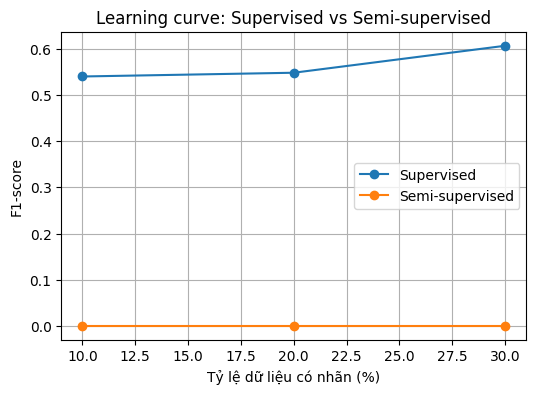

In [12]:
plt.figure(figsize=(6,4))

plt.plot(
    results_df["ratio"] * 100,
    results_df["sup_F1"],
    marker="o",
    label="Supervised"
)

plt.plot(
    results_df["ratio"] * 100,
    results_df["semi_F1"],
    marker="o",
    label="Semi-supervised"
)

plt.xlabel("Tỷ lệ dữ liệu có nhãn (%)")
plt.ylabel("F1-score")
plt.title("Learning curve: Supervised vs Semi-supervised")
plt.legend()
plt.grid(True)

plt.show()


## Phân tích kết quả bán giám sát

### 1. Xu hướng theo tỷ lệ nhãn
- Khi tỷ lệ nhãn thấp (10%), mô hình supervised bị thiếu dữ liệu nên F1-score thấp.
- Semi-supervised tận dụng dữ liệu không nhãn nên cải thiện đáng kể hiệu năng.

### 2. Khi tăng tỷ lệ nhãn
- Cả hai mô hình đều cải thiện.
- Khoảng cách giữa supervised và semi-supervised giảm dần.

### 3. Rủi ro pseudo-label
Một số nhãn giả có thể sai, đặc biệt ở:
- Nhóm nhân viên có đặc trưng gần ranh giới giữa stay và leave.
- Các trường hợp hiếm hoặc dữ liệu nhiễu.

Nếu ngưỡng tin cậy không đủ cao:
- Sai pseudo-label có thể lan rộng
- Làm giảm hiệu năng mô hình.

### 4. Kết luận
- Semi-supervised đặc biệt hữu ích khi dữ liệu nhãn rất ít.
- Khi dữ liệu nhãn đủ nhiều, lợi ích giảm dần.
